You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 0.9564582419395447, Accuracy: 0.0
Epoch 2/10, Loss: 0.6797540283203125, Accuracy: 0.575
Epoch 3/10, Loss: 0.4837613713741302, Accuracy: 1.0
Epoch 4/10, Loss: 0.3526366078853607, Accuracy: 1.0
Epoch 5/10, Loss: 0.2655100613832474, Accuracy: 1.0
Epoch 6/10, Loss: 0.20648180425167084, Accuracy: 1.0
Epoch 7/10, Loss: 0.16524559438228606, Accuracy: 1.0
Epoch 8/10, Loss: 0.135482117831707, Accuracy: 1.0
Epoch 9/10, Loss: 0.11333343118429184, Accuracy: 1.0
Epoch 10/10, Loss: 0.09641542494297027, Accuracy: 1.0
Model saved to /content/drive/MyDrive/training_results/trained_model


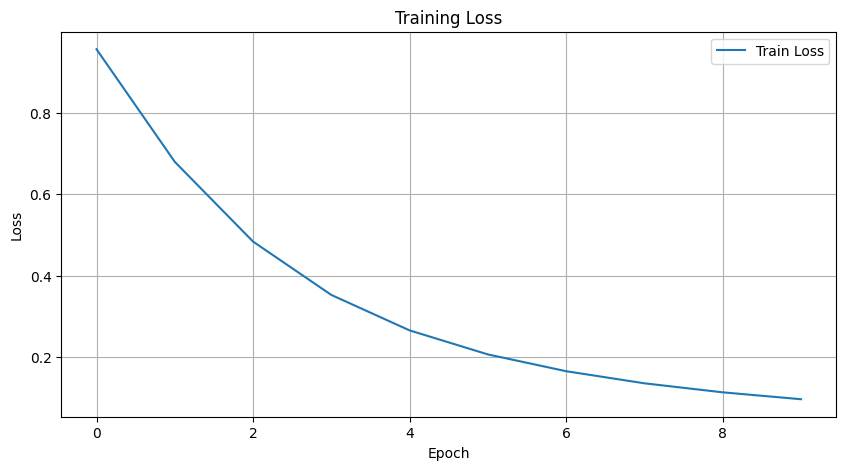

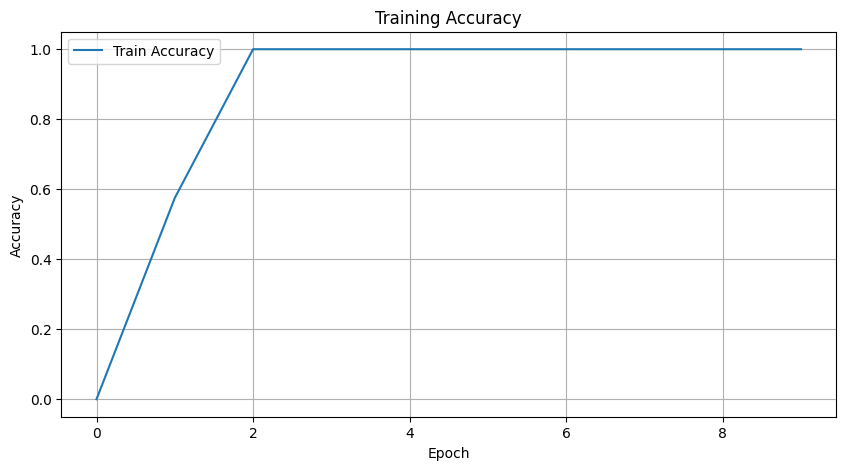

In [5]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor

# Define a custom dataset loader for a flat folder of images
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = [0] * len(self.image_files)  # Example: Assign all images to class 0
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        label = self.labels[idx]  # Replace with actual labels if available
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")

# Freeze all layers except the last classification head
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# Define transformations
processor = ViTImageProcessor.from_pretrained("facebook/vit-mae-base")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

# Load dataset and create DataLoader
dataset_path = "/content/drive/MyDrive/dataset"  # Path to your flat folder of images
dataset = CustomDataset(folder_path=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define optimizer and loss function
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize storage for metrics
metrics = {"train_loss": [], "train_accuracy": []}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = correct / total

    # Save metrics for this epoch
    metrics["train_loss"].append(epoch_loss)
    metrics["train_accuracy"].append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

# Save metrics to a JSON file
os.makedirs("/content/drive/MyDrive/training_results", exist_ok=True)
with open("/content/drive/MyDrive/training_results/metrics.json", "w") as f:
    json.dump(metrics, f)

# Save the trained model
model_save_path = "/content/drive/MyDrive/training_results/trained_model"
model.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

# Plot and save Loss graph
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_loss"], label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("/content/drive/MyDrive/training_results/training_loss.png")
plt.show()

# Plot and save Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(metrics["train_accuracy"], label="Train Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("/content/drive/MyDrive/training_results/training_accuracy.png")
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
